In [1]:
from matplotlib import pyplot as plt
from rnaseq3 import RNAseq as RNAseq3
from os.path import expanduser as exusr
from CellModels.Cells.IO import CellReader
from CellModels.Cells.Filters import Masks
from CellModels.Clustering.IO import ClusteringReader
import numpy as np
import pandas as pd
import logging

logging.basicConfig(level=logging.ERROR)

In [2]:
aerts_seq = RNAseq3(exusr('~/Google Drive File Stream/My Drive/Projects/RDN-WDP/contrib/scRNAseq/EyeAntennal_Combined_DG2_v4.csv'))
ariss_seq = RNAseq3(exusr('~/Google Drive File Stream/My Drive/Projects/RDN-WDP/contrib/GSE115476_RAW/GSM3178869_DMS.expr.txt'))
aerts = aerts_seq.data
ariss = ariss_seq.data

In [3]:
clustered = ClusteringReader.read(exusr('~/Google Drive File Stream/My Drive/Projects/RDN-WDP/processing/clustering/bigc100k6n20r1000_metadata.yml'))
clustered.cells

m = Masks(clustered.cells)

In [4]:
c = clustered.cells
genes = c.genes
cluster_names = {
    1: 'R8 ato(+)',
    2: 'MF ato(+++)',
    3: 'peripodial',
    4: 'posterior',
    5: 'anterior',
    6: 'MF ato(+)',
    7: 'non-R8'
}

c.loc[m.cells_mf_area & (c[('Cluster', 'ward', 6)] == 4), ['Cluster']] = 7

In [5]:
from scipy.stats import zscore

gcv = c.set_index(('Cluster', 'ward', 6), append=True) \
    .droplevel('Sample') \
    .rename_axis(index={('Cluster', 'ward', 6): 'Cluster'}) \
    .reorder_levels(['Gene', 'Cluster', 'Nucleus']) \
    .rename(columns={('Measurements', 'Normalized', 'Venus'): 'Normalized'}) \
    .sort_index() \
    .sort_index(axis='columns') \
    .xs(('Measurements', 'Normalized'), axis='columns', drop_level=True) \
    .loc[:, ['Venus']]
gcv['Zscore'] = np.nan

z_aerts = pd.DataFrame()
z_ariss = pd.DataFrame()

for gene in c.genes:
    gcv.loc[gene, 'Zscore'] = zscore(np.log2(gcv.loc[gene, 'Venus'] + 1e-100))
    try:
        z_aerts[gene] = zscore(np.log2(aerts[gene] + 1))
    except KeyError:
        z_aerts[gene] = np.nan
    try:
        z_ariss[gene] = zscore(np.log2(ariss[gene] + 1))
    except KeyError:
        z_ariss[gene] = np.nan

In [6]:
genes = []
for gene in c.genes:
    if gene in aerts.columns or gene in ariss.columns:
        genes.append(gene)
if len(genes) % 2 != 0:
    genes.append(None)

In [7]:
from sklearn.neighbors import KernelDensity
from scipy.integrate import quad_vec

from CellModels.Cells.Filters import QC
from CellModels.Cells.Tools import CleanUp

excluded = [CleanUp.SYNONYMS[x] if x in CleanUp.SYNONYMS else x for x in QC.GENES_BAD]
excluded.append('seq')

densities = {}
genes2 = []
for gene in genes:
    if gene in excluded:
        continue
    else:
        genes2.append(gene)
        densities[gene] = {}
        for cl in gcv.index.unique('Cluster'):
            densities[gene][cl] = KernelDensity(kernel='gaussian', bandwidth=0.25) \
                .fit(gcv.loc[(gene, cl), 'Zscore'].values.reshape(-1, 1))

In [8]:
from scipy.integrate import quad

def map_sc_seq(ds):
    vals = np.ones((ds.shape[0], len(gcv.index.unique('Cluster'))))
    for gene in genes2:
        for j, c in enumerate(gcv.index.unique('Cluster')):
            cache = {}
            for i, v in enumerate(ds[gene]):
                if not v in cache:
                    cache[v] = quad(lambda x: np.exp(densities[gene][c].score_samples([[x]])), v-0.125, v+0.125)[0]
                vals[i][j] = vals[i][j] * cache[v]

    return np.argmax(vals, axis=1)

In [9]:
aerts['Cluster'] = map_sc_seq(z_aerts) + 1.0
z_aerts['Cluster'] = aerts['Cluster'].values

ariss['Cluster'] = map_sc_seq(z_ariss) + 1.0
z_ariss['Cluster'] = ariss['Cluster'].values

/usr/local/anaconda3/envs/rdn-wdp-new/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


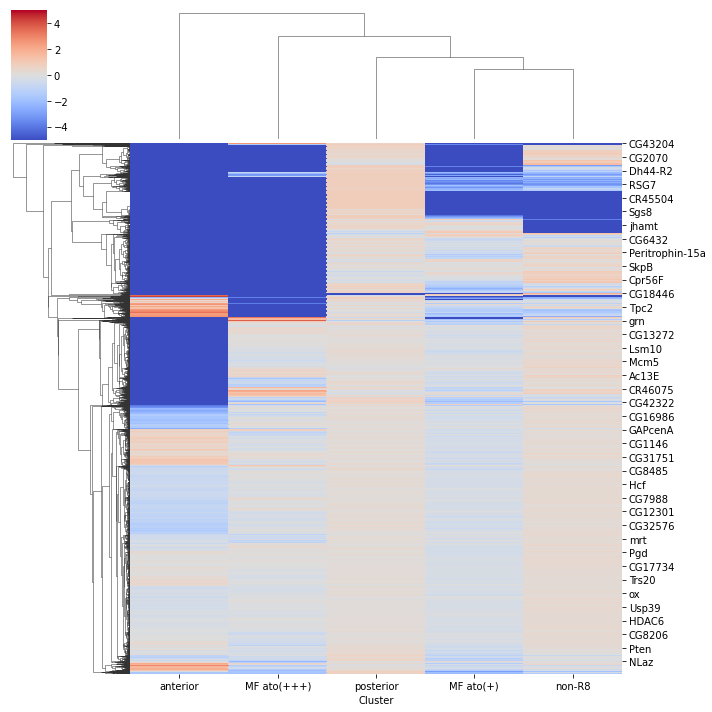

In [10]:
import seaborn as sns

m_aerts = aerts.drop(['Unnamed: 0', 'Cluster'], axis=1).mean(axis=0)
h_aerts = np.log(aerts.drop(['Unnamed: 0'], axis=1) \
                      .groupby('Cluster')
                      .mean() / m_aerts + np.e**-10) \
            .replace(np.nan, 0)
g = sns.clustermap(h_aerts.rename(cluster_names) \
                          .drop('peripodial') \
                          .transpose()
                          .clip(lower=-5, upper=5), cmap="coolwarm", center=0)

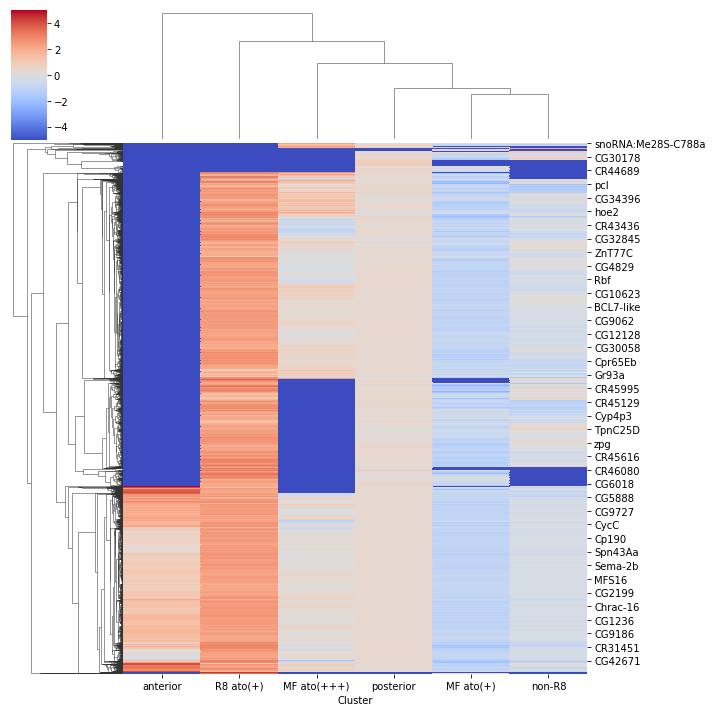

In [11]:
m_ariss = ariss.drop(['Cluster'], axis=1).mean(axis=0)
h_ariss = np.log(ariss.groupby('Cluster') \
                      .mean() / m_ariss + np.e**-10) \
            .replace(np.nan, 0)
g = sns.clustermap(h_ariss.rename(cluster_names) \
                          .transpose() \
                          .clip(lower=-5, upper=5), cmap="coolwarm", center=0)

In [12]:
library(BBmisc)
library(SingleCellExperiment)
library(scater)
library(scran)


Attaching package: ‘BBmisc’


The following object is masked from ‘package:base’:

    isFALSE


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowM

In [13]:
%put r_aerts r_ariss r_imaging genes --to R
r_aerts = aerts
r_ariss = ariss
r_imaging = c

In [14]:
type(aerts)

pandas.core.frame.DataFrame

In [15]:
r_imaging

ERROR: Error in eval(expr, envir, enclos): object 'r_imaging' not found
